## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
#sns.set(font_scale = 2)

import warnings
warnings.filterwarnings('ignore')

import utils

In [2]:
train_data, test_data = [pd.read_csv("datasets/titanic/" + filename) for filename in ("train_data.csv", "test_data.csv")]

### Droping some not useful columns



In [3]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Title', 'PeopleInTicket',
       'FarePerPerson'],
      dtype='object')

In [4]:
#[utils.fill_null_values(df_ = df, column_ = ['PassengerId', 'Title'], method = 'REMOVE') for df in [train_data, test_data]]

In [5]:
# female equals 0 and male equals 1 in the sex column
#train_data['Sex'] = train_data['Sex'].map({'female': 0, 'male': 1})

# C = 0, Q = 1, S = 2 in the embarked column
#train_data['Embarked'] = train_data['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# check if all the values have been remapped
#print("Unique values 'Sex': {}".format(train_data['Sex'].unique()))
#print()
#print("Unique values 'Embarked': {}".format(train_data['Embarked'].unique()))

train_data['FamSize'] = train_data["SibSp"] + train_data["Parch"] + 1
test_data['FamSize'] = test_data["SibSp"] + test_data["Parch"] + 1


## Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an open-ended process where we make plots and calculate statistics in order to explore our data. The purpose is to to find anomalies, patterns, trends, or relationships. These may be interesting by themselves (for example finding a correlation between two variables) or they can be used to inform modeling decisions such as which features to use. In short, the goal of EDA is to determine what our data can tell us! EDA generally starts out with a high-level overview, and then narrows in to specific parts of the dataset once as we find interesting areas to examine.


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,PeopleInTicket,FarePerPerson,FamSize
PassengerId,1.000000,-0.005007,-0.035144,0.037726,-0.057527,-0.001652,0.012658,-0.006376,0.006161,-0.040143
Survived,-0.005007,1.000000,-0.338481,-0.064444,-0.035322,0.081629,0.257307,0.064962,0.288337,0.016639
Pclass,-0.035144,-0.338481,1.000000,-0.398897,0.083081,0.018443,-0.549500,-0.039893,-0.762981,0.065997
Age,0.037726,-0.064444,-0.398897,1.000000,-0.301570,-0.207475,0.107336,-0.263232,0.337613,-0.309764
SibSp,-0.057527,-0.035322,0.083081,-0.301570,1.000000,0.414838,0.159651,0.727331,-0.073529,0.890712
Parch,-0.001652,0.081629,0.018443,-0.207475,0.414838,1.000000,0.216225,0.638361,-0.036442,0.783111
Fare,0.012658,0.257307,-0.549500,0.107336,0.159651,0.216225,1.000000,0.436544,0.827073,0.217138
PeopleInTicket,-0.006376,0.064962,-0.039893,-0.263232,0.727331,0.638361,0.436544,1.000000,0.054931,0.816020
FarePerPerson,0.006161,0.288337,-0.762981,0.337613,-0.073529,-0.036442,0.827073,0.054931,1.000000,-0.068460
FamSize,-0.040143,0.016639,0.065997,-0.309764,0.890712,0.783111,0.217138,0.816020,-0.068460,1.000000


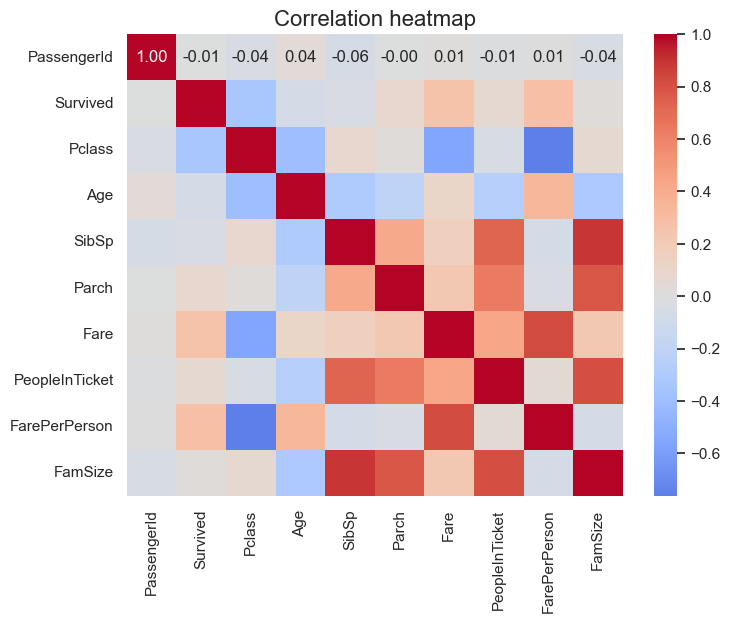

In [6]:
corr_mat = train_data.select_dtypes(include=['number']).corr()

display(corr_mat)

# create the heatmap plot using seaborn
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(corr_mat, annot=True, fmt=".2f", xticklabels=corr_mat.columns, yticklabels=corr_mat.columns, cmap="coolwarm", center=0)

plt.title("Correlation heatmap", size=16)

plt.show()



The plot shows that only a few features seem to correlate with eachother which means that most columns carry some unique information. The strongest correlations can be found between family size and the number of siblings/spouses/parents/children and fare prize and passenger class which is expected but nevertheless I will keep all these columns in the data for the rest of the analysis.

One can also see that the survival rate is mostly affected by the the passenger sex (-0.54), passenger class (-0.34) and the fare prize (0.26).

So let us have a look at the individual features.

For the categorical features (Pclass, Sex, Embarked) one can simply group the survival rates by the unique values and calculate their mean survival rate. For the features Sex and and Embarked the numerical values were mapped back to their categories for better readability.


In [7]:
train_data[['Pclass', 'Survived']].groupby('Pclass', as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


* **pclass**: ticket class with values [1,2,3] = [Upper, Middle, Lower]
In the plots we can see that more than 50% of the passengers bought lower class tickets. 
Unsurprisingly: the higher your class, the more likely you are to survive.

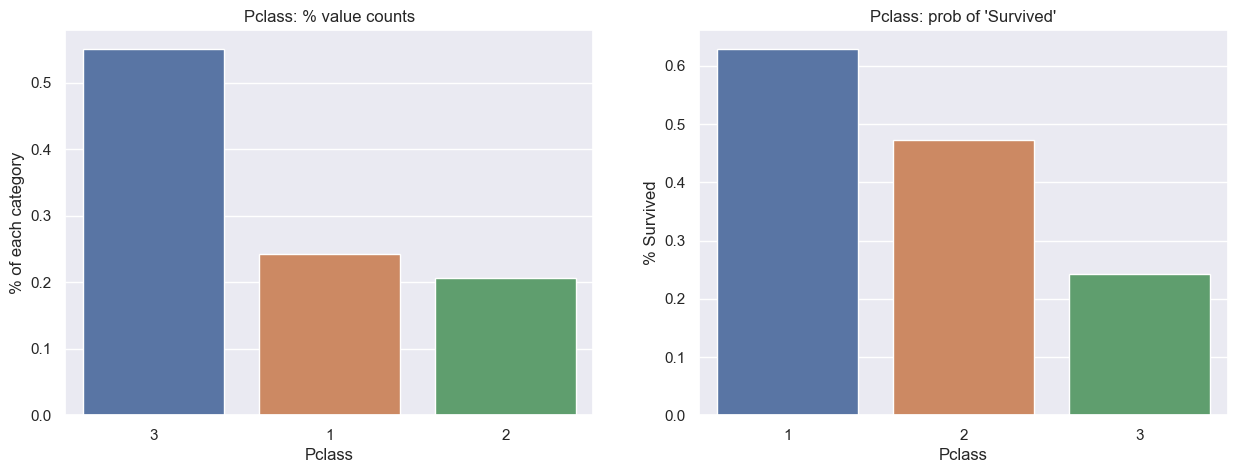

In [8]:
utils.eda_bars_plot(df_=train_data, feature='Pclass')

In [9]:
train_data[['Sex', 'Survived']].groupby('Sex', as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


* **sex**: We can see that only 35% of the passengers were females, but women had more than a 70% chance of surviving!. This means that we could build a classifier that predicts survival only for women (and death for men), and would achieve a decent accuracy. It could serve as a good first result (baseline).

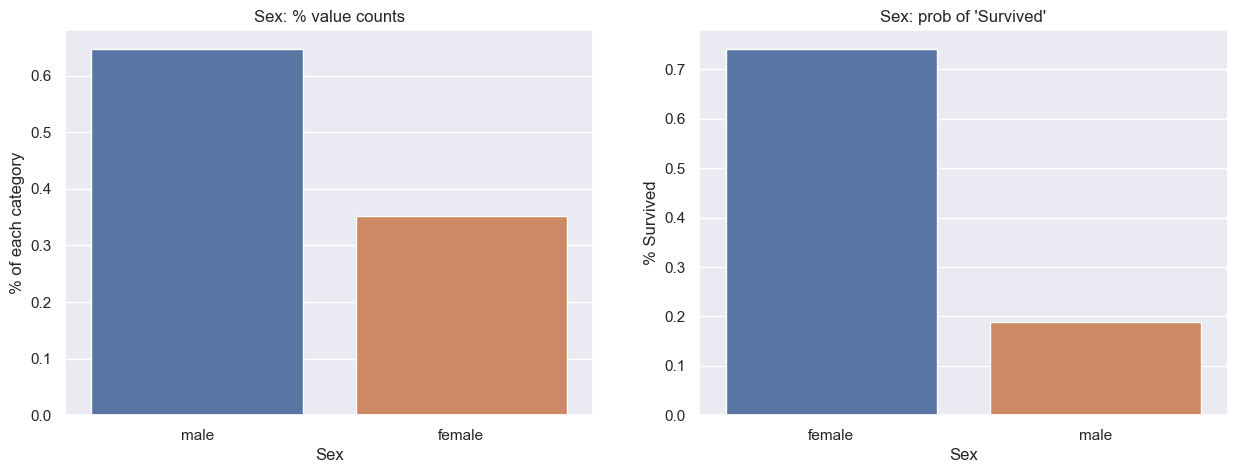

In [10]:
utils.eda_bars_plot(df_=train_data, feature='Sex')

In [11]:
embarked_survival = train_data[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean()

# remapping
embarked_survival.loc[embarked_survival['Embarked'] == 0, 'Embarked'] = 'C'
embarked_survival.loc[embarked_survival['Embarked'] == 1, 'Embarked'] = 'Q'
embarked_survival.loc[embarked_survival['Embarked'] == 2, 'Embarked'] = 'S'

embarked_survival

,Embarked,Survived
0,C,0.558824
1,Q,0.389610
2,S,0.336957


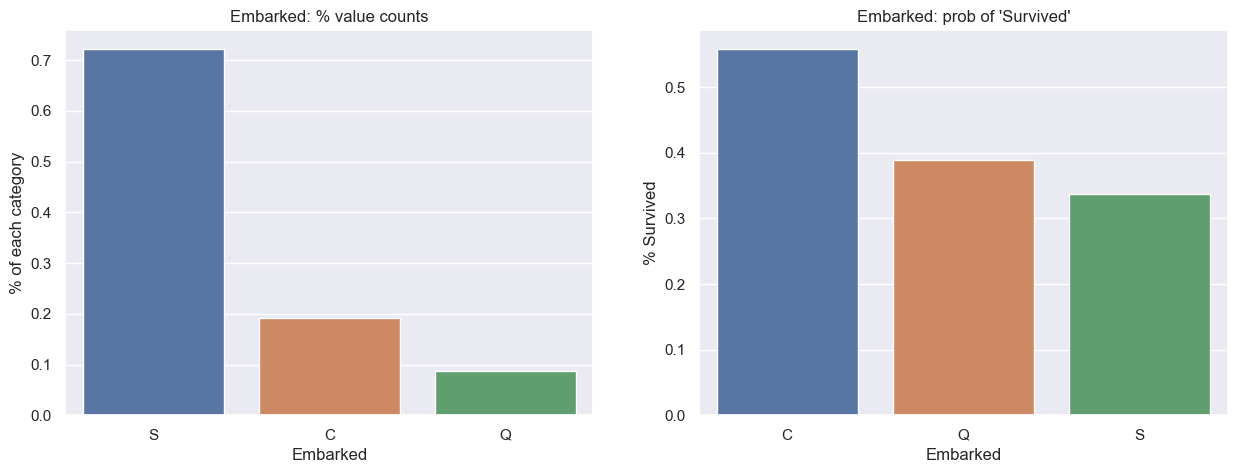

In [12]:
utils.eda_bars_plot(df_=train_data, feature='Embarked')

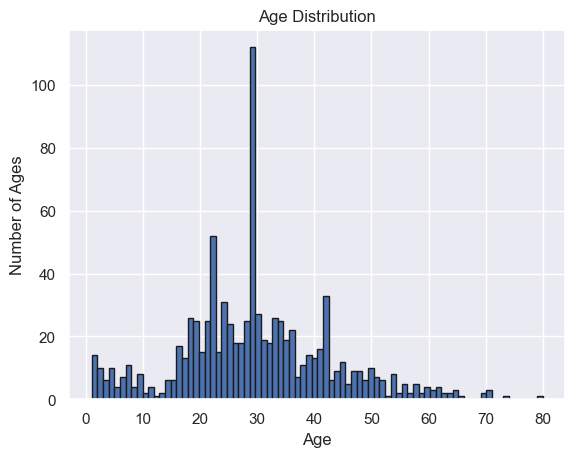

In [52]:
#plt.pfigsize(8, 8)


# Histogram of the Energy Star Score
#plt.style.use('fivethirtyeight')
plt.hist(train_data['Age'].dropna(), bins = 80, edgecolor = 'k');
plt.xlabel('Age'); plt.ylabel('Number of Ages'); 
plt.title('Age Distribution');

In [14]:

train_data['AgeGroup'] = 0
# labels for the different age groups
age_groups = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80'] # age groups

# split the passengers into age groups of 10 years
train_data['AgeGroup'] = pd.cut(train_data['Age'], range(0, 90, 10), labels=age_groups)

def age_group_summary(df, age_groups):
    """Create a result summary for the different age groups."""
    # calculate the survival rates and counts for the different age groups
    age_survival = df[['AgeGroup', 'Survived']].groupby('AgeGroup').agg(['mean', 'count', 'sum'])
    
    # reindex to get the correct order in the calculated data frame
    age_survival = age_survival.reindex(age_groups)
    
    # change the column headers
    age_survival.columns = age_survival.columns.droplevel() # remove multilevel index
    age_survival.columns = ['Survival rate', 'Total', 'Survived']
    
    # create a new column containing the number of passengers that died
    age_survival['Died'] = age_survival['Total'] - age_survival['Survived']
    
    return age_survival
    
# calculate the survival rates for the different age groups
age_survival = age_group_summary(train_data, age_groups)

age_survival



,Survival rate,Total,Survived,Died
AgeGroup,,,,
1-10,0.539474,76,41,35
11-20,0.382609,115,44,71
21-30,0.319885,347,111,236
31-40,0.448276,174,78,96
41-50,0.400000,115,46,69
51-60,0.404762,42,17,25
61-70,0.235294,17,4,13
71-80,0.200000,5,1,4


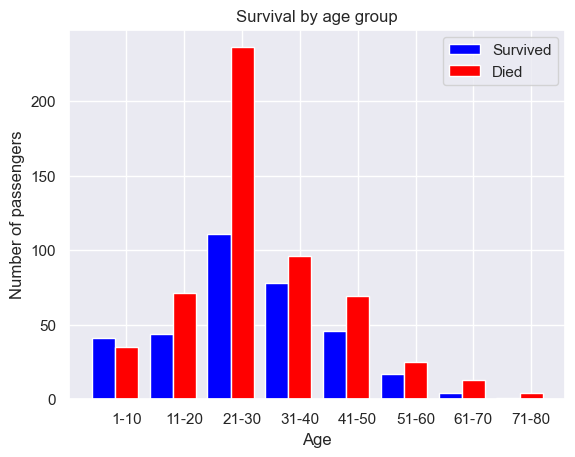

In [15]:
ind = np.arange(len(age_survival))

# bar width
width = 0.4

# bar plot
fig, ax = plt.subplots()

survived = age_survival['Survived'].values
bar1 = ax.bar(ind, survived, width=width, color='blue', label='Survived')

died = age_survival['Died'].values
bar2 = ax.bar(ind + width, died, width=width, color='red', 
              label='Died')

# format plot
ax.set(xlabel='Age', xticks=(ind + width), xticklabels=age_groups, ylabel='Number of passengers', 
       title='Survival by age group')
plt.legend()

plt.show()



The results from the age group analysis show little children (1-10 years) had the highest chance of survival from all the groups. The lowest survival rates were observed for passengers between 21 - 30 years, 61 - 70 years and 71 - 80 years.

To have a look at the influence of gender and age on passenger survival the data set is split into male and female passengers and the analysis for age groups from above is repeated.


# Scaling Features

The final step to take before we can build our models is to scale the features. This is necessary because features are in different units, and we want to normalize the features so the units do not affect the algorithm.



In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#numerical pipeline
num_pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])

In [17]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [18]:
#categorical pipeline
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

In [60]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [61]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56136529,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.62213421,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.26549042, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-1.67089607,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.26549042, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.17832189, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [62]:
y_train = train_data["Survived"]

## Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [64]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [65]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

In [66]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.812621722846442

#### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)


LogisticRegression(random_state=42)

In [69]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = lr.predict(X_test)

In [73]:
logistic_scores = cross_val_score(lr, X_train, y_train, cv=10)
logistic_scores.mean()

0.8035830212234707

## Adaboost

In [75]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier()
adb.fit(X_train, y_train)

X_test = preprocess_pipeline.transform(test_data)
y_pred = adb.predict(X_test)

ada_scores = cross_val_score(adb, X_train, y_train, cv=10)
ada_scores.mean()

0.8137203495630461

In [49]:
passenger_id = test_data['PassengerId']

submissions = pd.DataFrame({
    'PassengerId': passenger_id,
    'Survived': y_pred
})

In [50]:
submissions.to_csv('datasets/titanic/submissions.csv', index=False)

In [51]:
submissions

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
